#  Global Annual Temperature Anomalies (degrees C) 1850-2015

Para el filtrado (filtro de Kalman y suavizado de intervalo fijo) usaremos la toolbok [E4](https://www.ucm.es/e-4/), para ello es necesario ejecutar lo siguiente:

In [450]:
clear
e4init


            XXXXXX 4 4      XXXXX  XX     XX  XX  XXXXXX (c)
           XX      444     XX  XX XX     XX  XX  XX
          XXXX       4    XXXXX  XX     XX  XX  XXXXXX
         XX              XX     XX     XX  XX      XX
        XXXXXX          XX     XXXXXX XXXXXX  XXXXXX

    Toolbox for State Space Estimation of Econometric Models
 
*********************** Options set by user ********************
Filter. . . . . . . . . . . . . : KALMAN
Scaled B and M matrices . . . . : NO
Initial state vector. . . . . . : AUTOMATIC SELECTION
Initial covariance of state v.  : IDEJONG
Variance or Cholesky factor?  . : VARIANCE
Optimization algorithm. . . . . : BFGS
Maximum step length . . . . . . : 0.100000
Stop tolerance. . . . . . . . . : 0.000010
Max. number of iterations . . . :       75
Verbose iterations. . . . . . . : YES
****************************************************************
 
 


Tambien es necesario cargar el toolbox de control

In [451]:
pkg load control

Cargamos los datos `gta.data` correspondientes a [Global and Hemispheric Temperature Anomalies - Land and Marine Instrumental Records](https://cdiac.ess-dive.lbl.gov/trends/temp/jonescru/jones.html) 

In [452]:
load gta.data

La decimocuarta columna de la matriz `gta` contiene los datos anuales correspondientes a los años 1850--2015. Por comodidad generamos la variable `y` con dichos datos anuales (es decir `p=1`).

In [453]:
y = gta(:,14);
p = 1;

y ahora vamos a representar los datos de la serie

In [5]:
%plot gnuplot
% title('Global Annual Temperature Anomalies')
% plot(y, 'r')

... pero mejor si las figuras se insertan en el propio notebook en formato `png`...

In [6]:
%plot --format png

y aún mejor si usamos las fechas en el eje horizontal, un grid vertical, etc. etc.

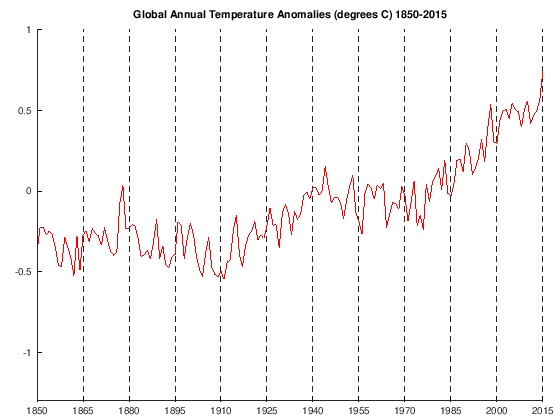

In [454]:
dates = gta(:,1);
yr = datenum (dates,1,1);
plot(yr, y, 'r')
set (gca(), "xtick", datenum (1850:15:2020,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
ylim([-1.3, 1])
title('Global Annual Temperature Anomalies (degrees C) 1850-2015')
box off;

Vamos a definir un rango de órdenes AR con los que trabajar. Puesto que los datos son anuales, es mejor usar órdenes autorregresivos largos para evitar identificar tendencias ruidosas (queremos que el pseudo espectro del componente de tendencia esté próximo a un pico espectral muy pegado al eje vertical, y esto solo es posible si usamos un polinomio autorregresivo de orden elevado).

In [534]:
rgar = [51:70];

In [535]:
#63./[1:31];
#PaP=63./[1,3,7,12,15,17,25,31]
#format long

Si no indicamos un modelo a priori, y además la periodicidad de los datos es anual `(p=1)`, entonces la toolbox `LDHR` intentará ajustar (_siempre que sea posible_) un modelo de tendencia IRW más ruido.

In [536]:
[VAR,P,TVP,oar]=autodhr(y,p,[],rgar)

VAR =

   4.658045203166136e-03   2.146566701538700e-06

P = Inf
TVP =

   1
   1

oar = 63


Usando este modelo, filtramos la serie (mediante _Fixed-Interval Smoothing_) para obtener los componentes

In [537]:
[Trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,12,0,0);

Vamos a dibujarlos (para que la figura sea más clara, desplazaremos hacia abajo el componente irregular)

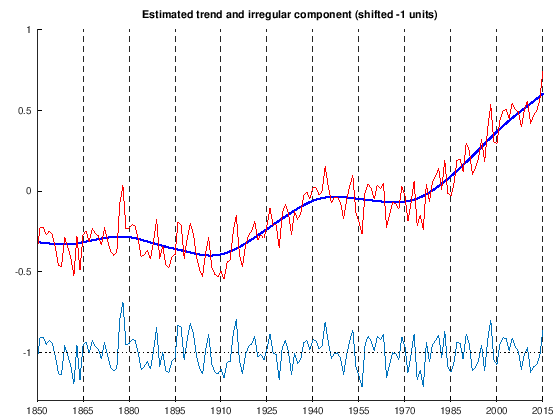

In [538]:
plot(yr, Trend, '-b', "linewidth", 4)
set (gca(), "xtick", datenum (1850:15:2015,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg-1)
plot(yr, -ones(length(y)), ':k')
ylim([-1.3, 1])
title('Estimated trend and irregular component (shifted -1 units)')
box off;

La tendencia muestra un comportamiento cíclico. Si ajustamos un polinomio AR (por ejemplo, con el ordén `oar` elegido por `autodhr`) y miramos la periodicidad asociada las raíces de mayor módulo, nos encontramos con un ciclo de aproximadamente 63 años. Además, parece que también hay picos espectrales (raíces con módulo proximo a 1) en frecuencias próxioa a algunos armónicos con periodicidad entera; en particular: $63/3=21$ y $63/9=9$. 

He probado con otros armónicos no enteros... pero `autodhr` no logra identificar componentes `DHR` para dichos armónicos... esto me hace pensar que quizá el rítmico impulso anual (verano/invierno) hace que el sistema entre en resonancia justo en las frecuencias correspondientes a periodos con años completos... si no fuera así, querría decir que hay componentes armónicos tales que aumentan de temperatura unas veces en verano y otras en invierno (algo difícil de justificar). Afortunadamente no es el caso.

El siguiente código muestra las periodicidades (segunda columna) asociadas a las raíces de mayor módulo (tercera columna). Los periodos de los picos espectrales de interés a los que me refiero más arriba corresponden a las filas 3, 12 y 14):


	AR(53)

    aresp at line 134 column 3

 	 RAICES 	    NORMA 		 PERIODOS 
raices_polinomio =

 Column 1:

  -8.127097154744264e-01 + 5.820531800515701e-01i
  -9.975659618213824e-01 + 5.445737329556441e-02i
   9.965001320227094e-01 + 9.873070295649736e-02i
  -1.971510684326497e-01 + 9.745604785678506e-01i
   7.650090654627988e-01 + 6.311355616696067e-01i
   9.892481622796155e-01 + 1.899008422584678e-02i
  -5.697760324666299e-01 + 8.075281813428258e-01i
   5.280892719049321e-02 + 9.861843921854020e-01i
   3.609228894247073e-01 + 9.180792783988257e-01i
  -9.633204494747871e-01 + 2.101388885973964e-01i
   9.438461365541873e-01 + 2.836785433223896e-01i
   2.412235279411302e-01 + 9.499279492840058e-01i
   6.693348202788028e-01 + 7.148257300117904e-01i
  -3.546205565747609e-01 + 9.123150776842767e-01i
  -6.926689807597335e-01 + 6.915277044965912e-01i
   8.254583420034431e-01 + 5.248774455229407e-01i
   4.975992910102589e-01 + 8.398742149555705e-01i
  -4.256719400138407e-01 + 8.7449794556272

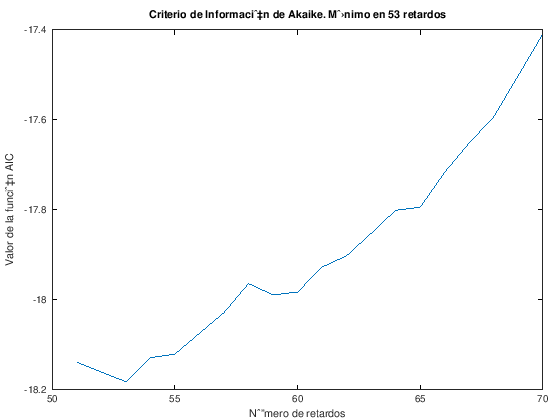

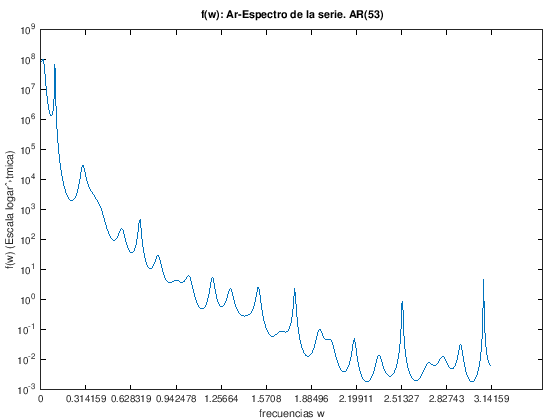

In [539]:
[ARSPT, S, LAGS, AR, ROOTS, NORM, P] = aresp(Trend,rgar,0,2);

In [540]:
[s,i]=sort(P,'descend');
format bank
R=[[1:10]',[P,NORM](i(1:10),:)];
R(R(:,3)>.98,:)

ans =

     1.00      Inf     1.04
     2.00   327.35     0.99
     3.00    63.62     1.00
     4.00    21.52     0.99
     8.00     9.11     0.99



In [542]:
PaP=63./[0,1,3,7]

PaP =

     Inf   63.00   21.00    9.00



Que corresponden a ciclos de periodo 63 y dos de sus armonicos de periodo entero (segundo y sexto armónicos):

Por tanto, vamos a intentar ajustar un modelo con _Tendencia_, un _Ciclo_ de 63 años y dos de sus armónicos (con periodos de 21 y 9 años) y un componente irregular.

In [543]:
#63./[0:floor(63/2)];
#PaP=63./[0,1,3,4,6,7,8,13,14,15,17,18,22,23,24,25,26,27,28];
format bank
63./[0,1,3,4,7,12]
63/12
63./[0,1,3,7,9,21]
format long

ans =

     Inf   63.00   21.00   15.75    9.00    5.25

ans = 5.25
ans =

     Inf   63.00   21.00    9.00    7.00    3.00



    dhrgraph at line 68 column 3
    autodhr at line 451 column 31


AR  NN R2T63.6      21.29.1
65  1  0.6746.7926-I  0.0000-I  0.0000-I  0.0000-R

68  1  0.6670.0000-I  0.0000-I  0.0000-I  0.0000-R
60  1  0.6421.8616-R  0.0000-I  0.0000-R  0.0183-R
75  1  0.6050.0000-I  0.0108-I  0.0000-I  0.0000-R
57  1  0.5990.0000-I  0.0129-R  0.0025-R  0.0272-R
55  1  0.5990.0000-I  0.0572-R  0.0021-R  0.0173-R
54  1  0.5980.0000-I  0.0929-R  0.0009-R  0.0152-R
52  1  0.5980.0000-I  0.2836-R  0.0049-R  0.0163-R
53  1  0.5970.0000-I  0.1281-R  0.0017-R  0.0106-R
66  1  0.5812.9846-I  0.0000-I  0.0000-I  0.0026-R
67  1  0.5773.0317-I  0.0000-I  0.0000-I  0.0123-R
51  1  0.5720.0000-I  0.5593-R  0.0000-R  0.0224-R
71  1  0.5610.0000-R  0.0001-I  0.0000-I  0.0000-R
73  1  0.5430.0000-R  0.0007-I  0.0000-I  0.0120-R
62  1  0.53824.2429-R  0.0000-I  0.0000-I  0.0986-R
58  1  0.5370.0000-I  1.1302-R  0.0185-R  0.0001-S
69  1  0.5370.0000-I  0.0000-R  0.0000-R  0.0000-R
59  1  0.5360.0000-I  0.6185-R  0.

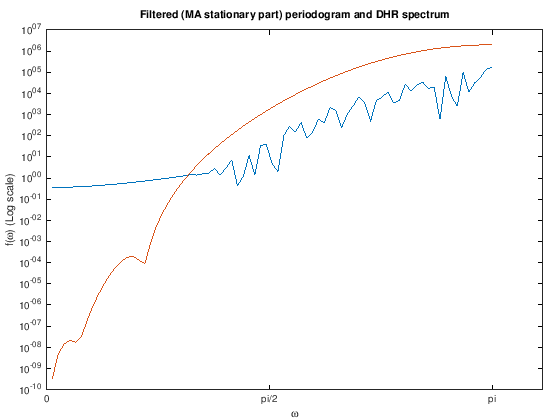

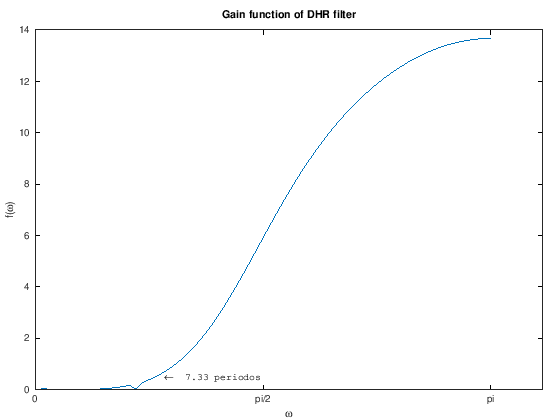

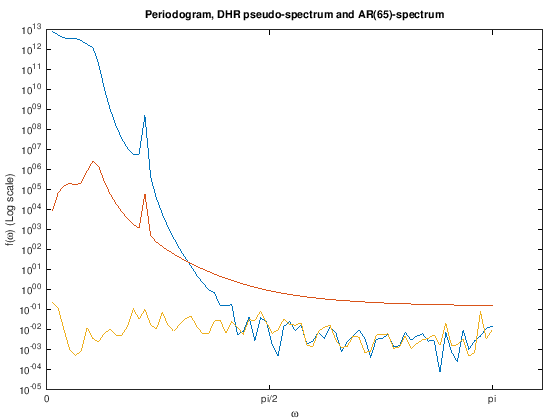

In [533]:
format long
#[VAR,P,TVP,oar,results,MCNN,NVR]=autodhr(y,1,[],rgar,63./[0,1,3,7,8,12,17,19,20,22,23,24,25,26,27,28])
#[VAR,P,TVP,oar,results,MCNN,NVR]=autodhr(y,1,[],[40:80],63./[0,1,3,7,12,15,17,25,31])
#[VAR,P,TVP,oar,results,MCNN,NVR]=autodhr(y,1,[],[40:80],63./[0,1,3,7,12,15,17,25,31],[1,1;1,0],1)
[VAR,P,TVP,oar,results,MCNN,NVR]=autodhr(y,1,[],rgar,PaP)

¡Parece que ha funcionado! Empleando las raices de un polinomio AR de orden 54, identifica una tendencia IRW y tres componentes cíclicos RW.

Obtengamos los componentes mediante el filtrado de la serie:

In [413]:
[Trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,12,2,0);

`Trend` es una matriz con tres columnas, la primera es la _Tendencia-Ciclo_, compuesta por la _Tendencia a largo plazo_ (segunda columna) más un _Ciclo_ formado por oscilaciones de periodos 63, 21 y 9 (tercera columna). Veámos dichos componentes:

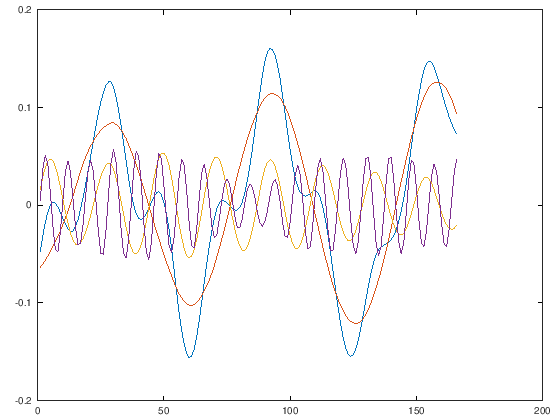

In [445]:
plot([cycle,season(:,2)])

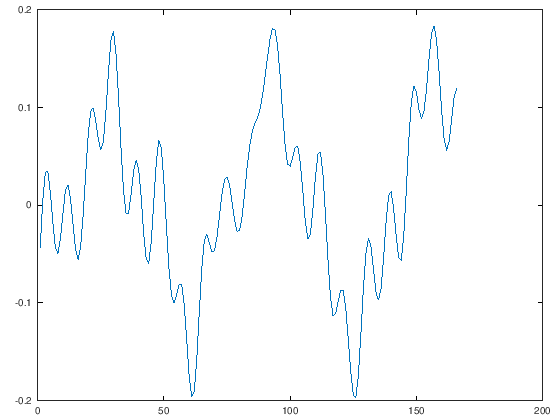

In [446]:
Ciclo=cycle(:,1)+season(:,2);
plot(Ciclo)

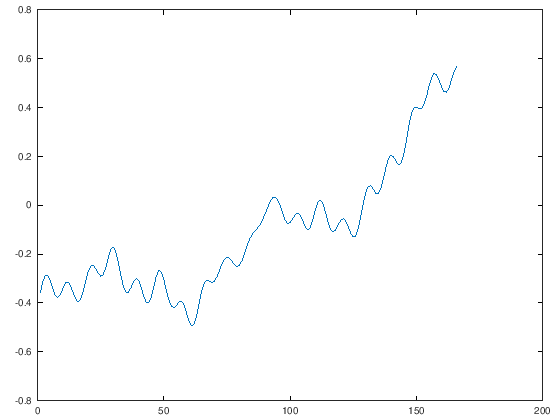

In [447]:
TC=Trend+Ciclo;
plot(TC)
Irr=y-TC;

Como se puede ver en la siguiente figura, la _Tendencia-Ciclo_ ajusta bastante bien la evolución de la serie [Global and Hemispheric Temperature Anomalies - Land and Marine Instrumental Records](https://cdiac.ess-dive.lbl.gov/trends/temp/jonescru/jones.html) 

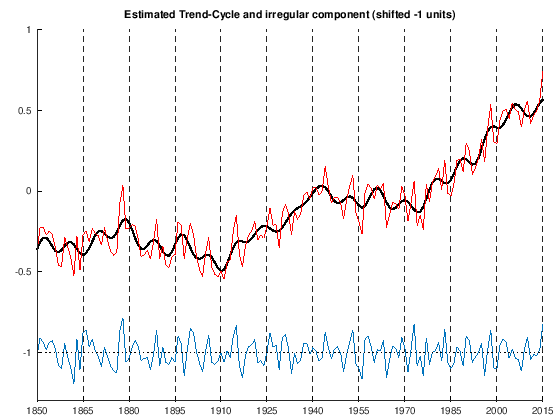

In [448]:
plot(yr, TC(:,1), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1850:15:2015,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, Irr-1)
plot(yr, -ones(length(y)), ':k')
ylim([-1.3, 1])
title('Estimated Trend-Cycle and irregular component (shifted -1 units)')
box off;

Aunque creo que es mucho más ilustrativo dibujar la _Tendencia_ a largo plazo por una parte, y el _Ciclo_ por otra, pues entonces se aprecia que aparentemente el _Ciclo_ replica el comportamiento de la serie [Atlantic Multidecadal Oscillation (AMO)](https://www.psl.noaa.gov/data/timeseries/AMO/) mostrado en el paper del Profesor Peter C. Young

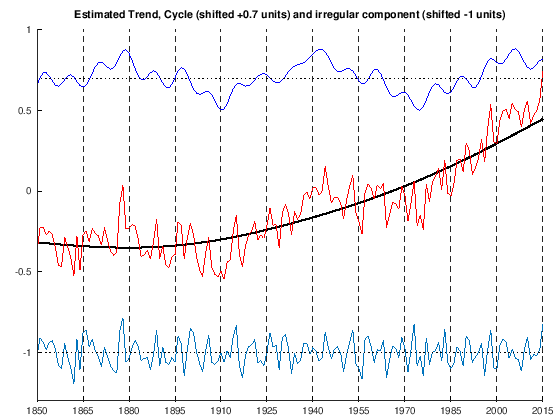

In [449]:
plot(yr, Trend(:,1), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1850:15:2015,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, Irr-1)
plot(yr, -ones(length(y)), ':k')
plot(yr, Ciclo(:)+0.7, '-b')
plot(yr, ones(length(y))*.7, ':k')
ylim([-1.3, 1])
title('Estimated Trend, Cycle (shifted +0.7 units) and irregular component (shifted -1 units)')
box off;

In [290]:
help aresp

'aresp' is a function from the file /home/marcos/Software/GNUoctave/OctMat/aresp.m

 -- Function File: aresp (Y)
 -- Function File: aresp (Y, LAG_RANGE)
 -- Function File: aresp (Y, LAG_RANGE, CRIT)
 -- Function File: aresp (Y, LAG_RANGE, CRIT, IA)
 -- Function File: [ARSPT, S, LAGS, AR, ROOTS, NORM, P] = aresp (...)

     Called with a single vector argument Y, calculates the AR-spectrum
     of the time series

     The variable LAG_RANGE is the range of AR orders.  By default
     'LAG_RANGE=[1 length(Y)/3]' (from AR(1) to AR(N/3)).

     The variable CRIT selects the information criterium used to select
     the AR order.  If given 'CRIT=0' (default value) the Akaike is
     used.  If given 'CRIT=1' then Bayesian.

     If 'IA=2' a graph and the roots of the AR polynomial are shown in
     the screen.

     Outputs

     ARSPT: AR-spectrum

     S : residual variance of AR model fitted to the series

     ARSPT
          AR-spectrum
     S
          residual variance of AR model fi


	AR(15)

    aresp at line 134 column 3

 	 RAICES 	    NORMA 		 PERIODOS 
raices_polinomio =

 Column 1:

   8.258527934384639e-01 + 4.103384430882424e-01i
  -9.214624018349281e-01 +                     0i
  -1.702723222018582e-01 + 8.695429014778294e-01i
  -7.777594513998523e-01 + 3.968314979103257e-01i
  -5.399682456729543e-01 + 6.856907782511977e-01i
   1.742265740163644e-01 + 8.364041411723956e-01i
   4.474138089658595e-01 + 7.131861826545929e-01i
   4.659584991053962e-01 + 4.574120415946636e-01i

 Column 2:

   9.221770298083751e-01 +                     0i
   9.214624018349281e-01 +                     0i
   8.860572900317990e-01 +                     0i
   8.731466096684748e-01 +                     0i
   8.727757728728847e-01 +                     0i
   8.543575284761131e-01 +                     0i
   8.419107123577707e-01 +                     0i
   6.529495376247324e-01 +                     0i

 Column 3:

   1.362540439253908e+01 +                     0i
   2.00000000000

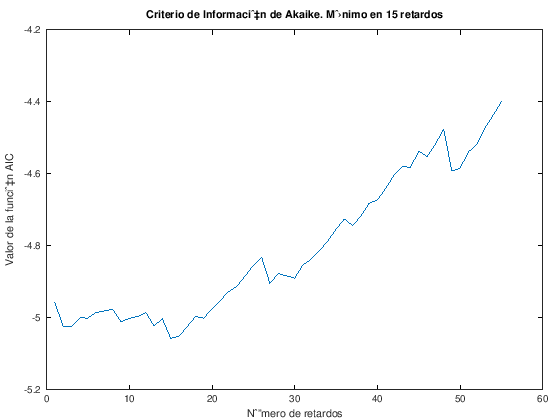

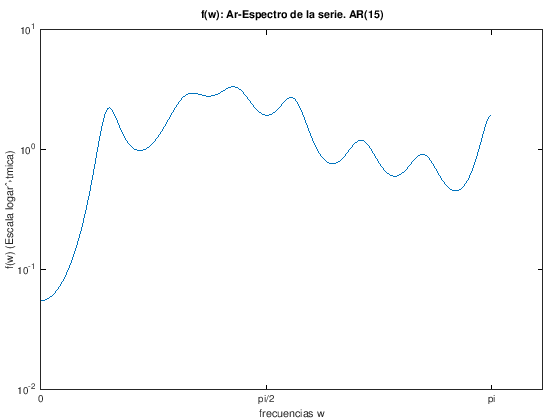

In [296]:
[ARSPT, S, LAGS, AR, ROOTS, NORM, P] = aresp(irreg,[],0,2);

In [443]:
load data4Marcos.mat

In [444]:
whos

Variables visible from the current scope:

variables in scope: top scope

   Attr Name         Size                     Bytes  Class
   ==== ====         ====                     =====  ===== 
        AR          51x1                        408  double
        ARSPT      512x1                       4096  double
        Ciclo      166x1                       1328  double
        Irr        166x1                       1328  double
        LAGS         1x1                          8  double
        MCNN         1x1                          8  double
        NORM        25x1                        200  double
        NVR          1x9                         72  double
        P            1x9                         72  double
        PaP          1x8                         64  double
   c    ROOTS       25x1                        400  double
        S            1x1                          8  double
        TC         166x1                       1328  double
        TVP          2x9   